The idea is to experiment different regression models such as lm, lasso, rf, etc along with the caret preprocess function. 
The database contains observations of weights and diameters of peaches.
The "true" relationship is a cubic function Weight=pulpDensity*(constant*(D)^3) + seedWeight.

Peach weight is the response variable.

# Data wrangling

In [1]:
library(tidyverse, warn.conflicts = F, quietly = T)
library(caret, warn.conflicts = F, quietly = T)
library(doParallel, warn.conflicts = F, quietly = T)
library(drc, warn.conflicts = F, quietly = T)
library(dbscan, warn.conflicts = F, quietly = T)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



'drc' has been loaded.


Please cite R and 'drc' if used for a publication,

for references type 'citation()' and 'citation('drc')'.




In [2]:
Data<-read_csv("duraznosfinal.csv")

New names:
* `` -> ...1

Rows: 1186 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (6): ...1, Zona, Finca, Peso, Diámetro Sutural, Diámetro Contrasutural

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
str(Data)

spec_tbl_df [1,186 × 6] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ ...1                  : num [1:1186] 1 2 3 4 5 6 7 8 9 10 ...
 $ Zona                  : num [1:1186] 1 1 1 1 1 1 1 1 1 1 ...
 $ Finca                 : num [1:1186] 301 1502 301 301 1502 ...
 $ Peso                  : num [1:1186] 147 87 139 159 128 83 94 129 105 125 ...
 $ Diámetro Sutural      : num [1:1186] 64 57 65 69 64 56 57 63.7 60 63 ...
 $ Diámetro Contrasutural: num [1:1186] 67 53 64 67 62 52 55 62.1 59 61 ...
 - attr(*, "spec")=
  .. cols(
  ..   ...1 = col_double(),
  ..   Zona = col_double(),
  ..   Finca = col_double(),
  ..   Peso = col_double(),
  ..   `Diámetro Sutural` = col_double(),
  ..   `Diámetro Contrasutural` = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [4]:
Data$`...1`<-NULL
Data$Zona<-as.factor(Data$Zona)
Data$Finca<-as.factor(Data$Finca)
Data<-rename(Data,"DS"="Diámetro Sutural");
Data<-rename(Data,"DCS"="Diámetro Contrasutural");

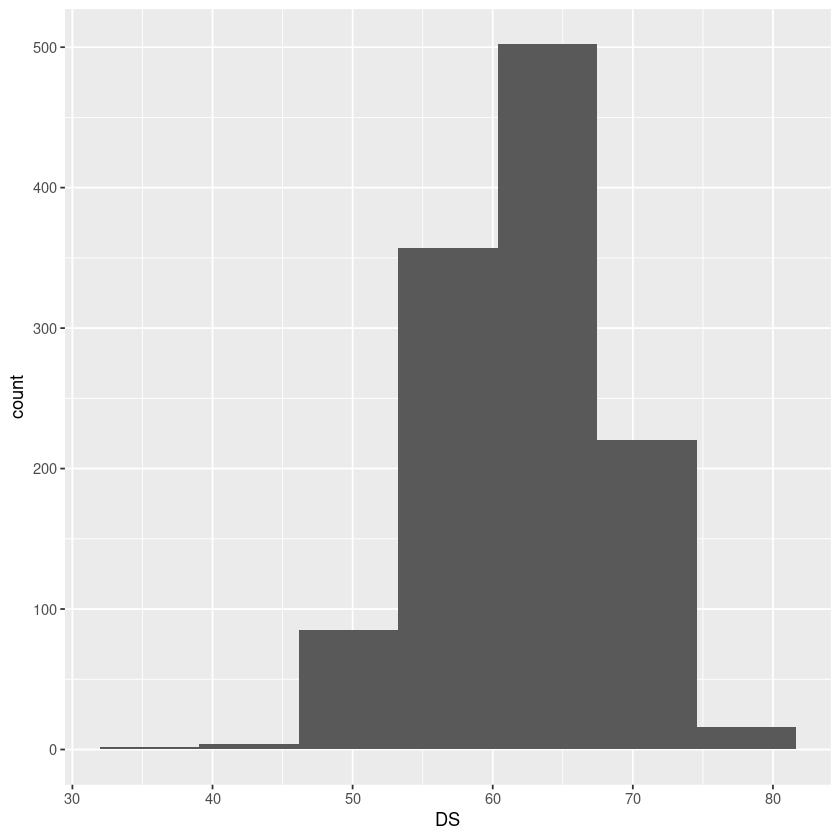

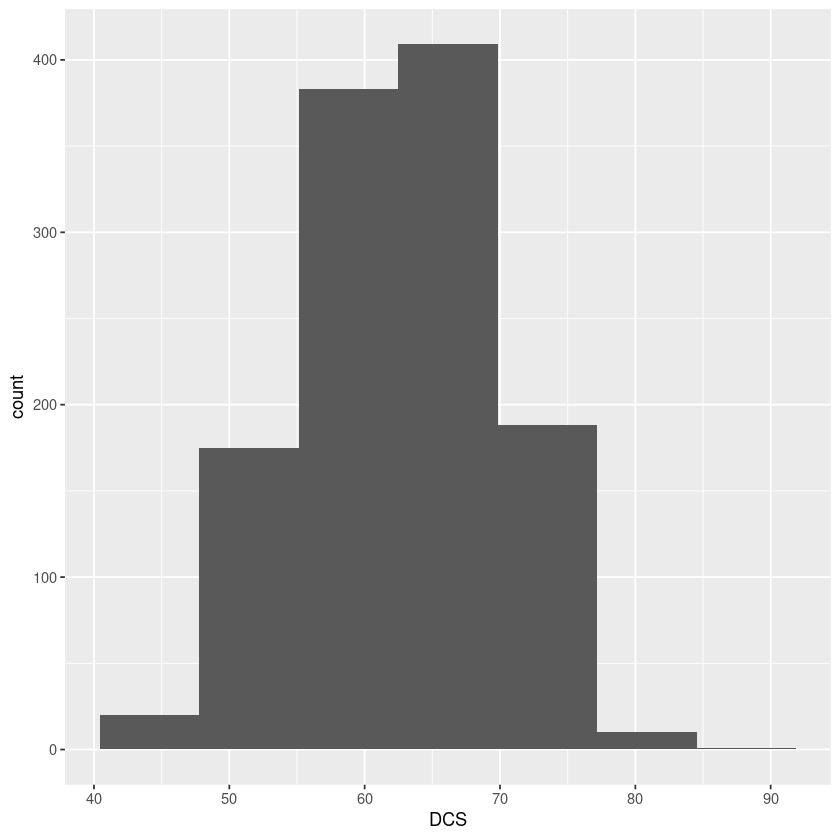

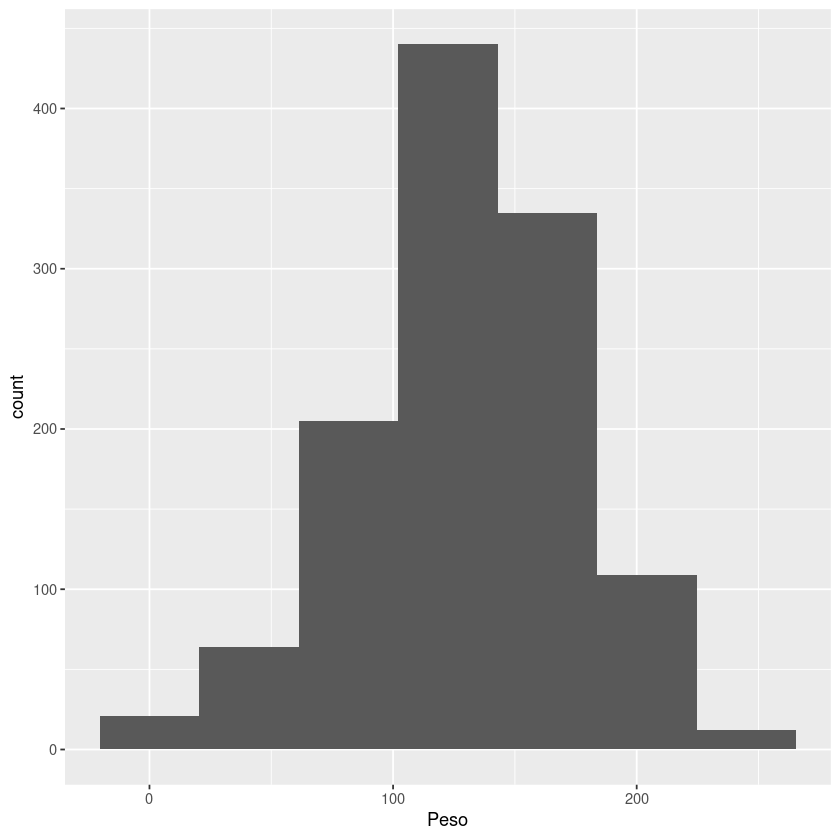

In [5]:
ggplot(data=Data,aes(DS))+
geom_histogram(bins=7)

ggplot(data=Data,aes(DCS))+
geom_histogram(bins=7)

ggplot(data=Data,aes(Peso))+
geom_histogram(bins=7)



  1   2   3 
606 200 380 


  101   102   201   301   303   401   501   601   701   801   901   902  1002 
   20   106    20   200    20    20    20    20    20    20    20    50    50 
 1032  1101  1201  1301  1401  1502  1601  1701  1801  1901 40801 40901 
   20    20    20    20    20   220    20    20    20    20   100   100 

`summarise()` has grouped output by 'Zona'. You can override using the
`.groups` argument.


Zona,Finca,n,mean,sd
<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,102,106,133.3774,25.29463
1,301,200,119.2400,27.61295
1,902,50,161.4400,22.74271
1,1002,50,173.7400,31.22519
1,1502,200,122.0150,27.67752
2,40801,100,48.4000,34.36935
2,40901,100,161.3000,31.74727
3,101,20,106.3000,16.65470
3,201,20,158.3500,22.48573


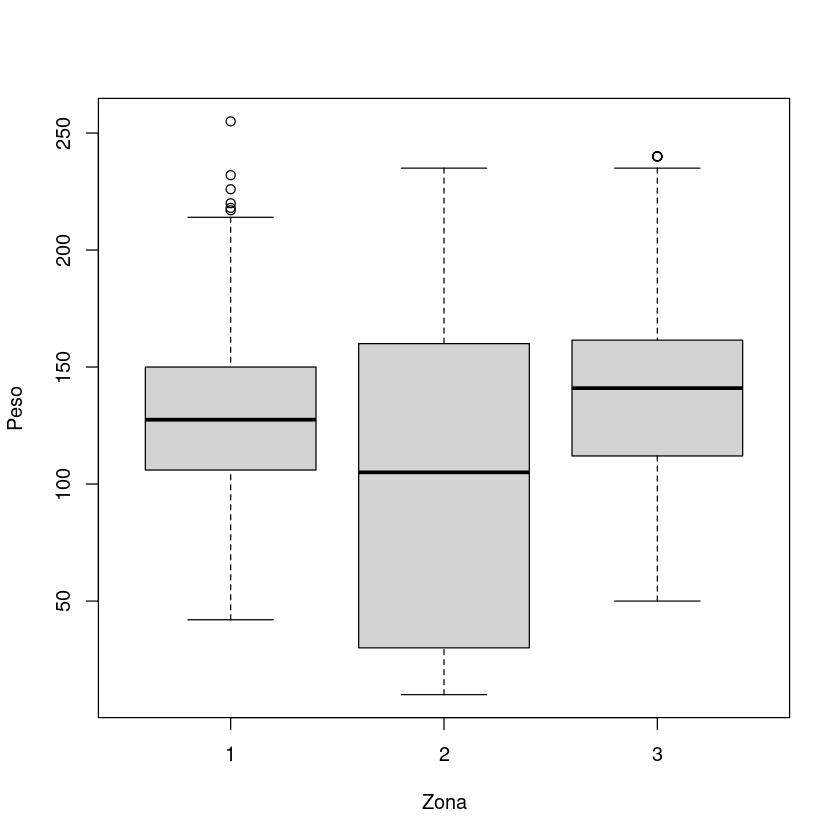

[1] "...1"                   "Zona"                   "Finca"                 
[4] "Peso"                   "Diámetro Sutural"       "Diámetro Contrasutural"

ERROR: Error in oneHot[, 1:3]: subíndice fuera de  los límites


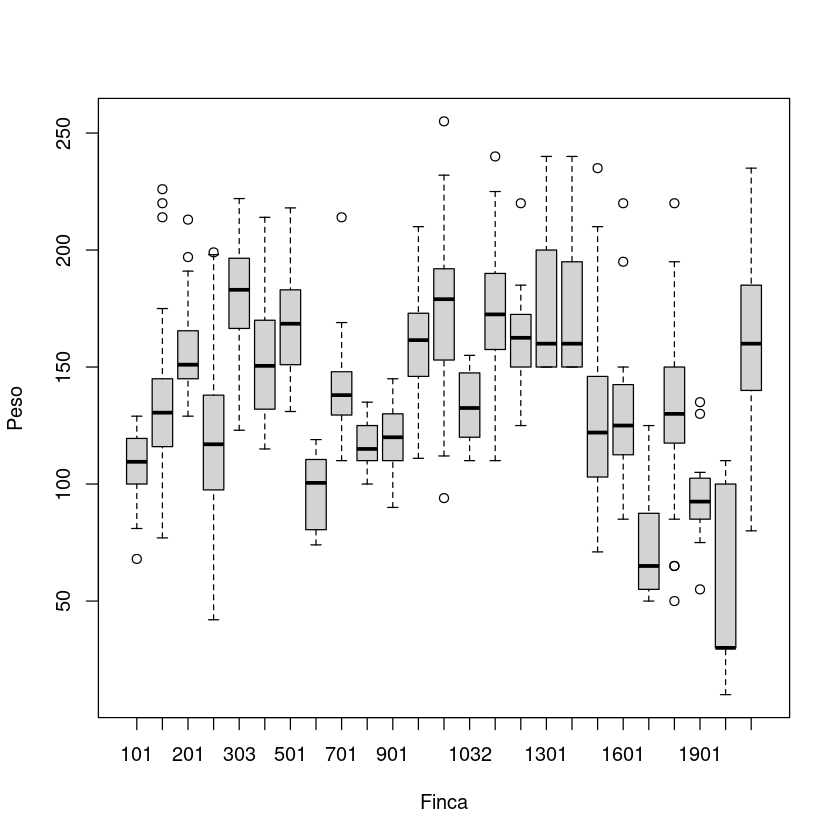

In [7]:
table(Data$Zona)
table(Data$Finca)
Data%>%group_by(Zona,Finca)%>%summarise(n=n(),mean=mean(Peso),sd=sd(Peso))

boxplot(Peso~Zona,data=Data)
boxplot(Peso~Finca,data=Data)


names(Data)
#xform to numerical space
dummies <- dummyVars(Peso ~ Zona+Finca, data = Data)
oneHot<-predict(dummies, newdata = Data)
CleanData<-Data%>%dplyr::select(-Zona,-Finca)%>%cbind(as.data.frame(oneHot[,1:3]),as.data.frame(oneHot[,4:28]))

#preProcValues <- preProcess(CleanData, method = c("center", "scale"))
#CleanData<-predict(preProcValues, CleanData)


FALSE  TRUE 
  218   968 

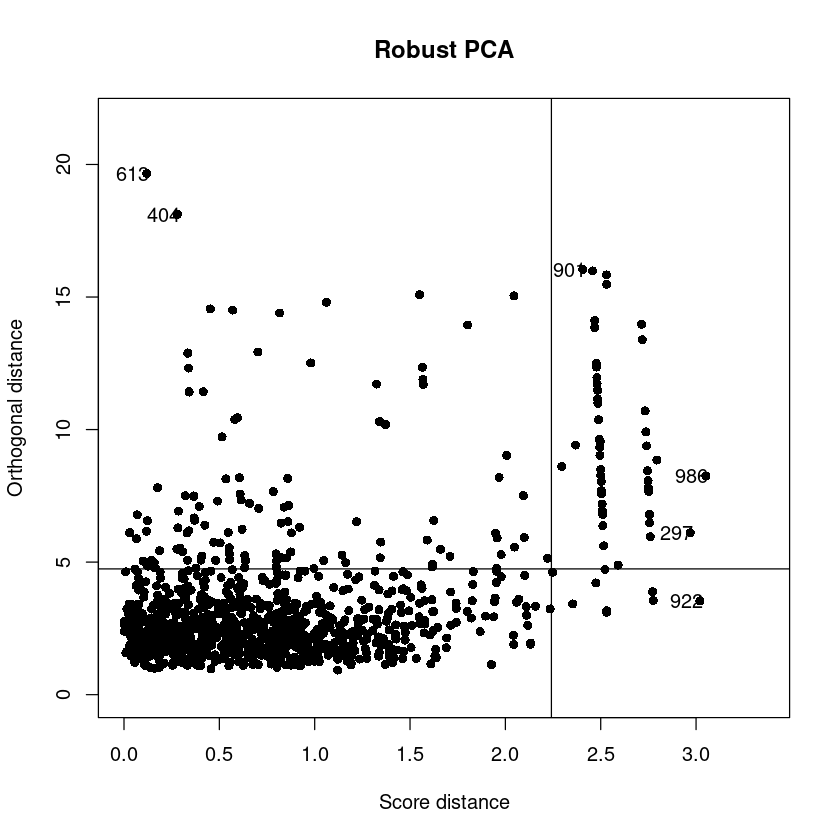

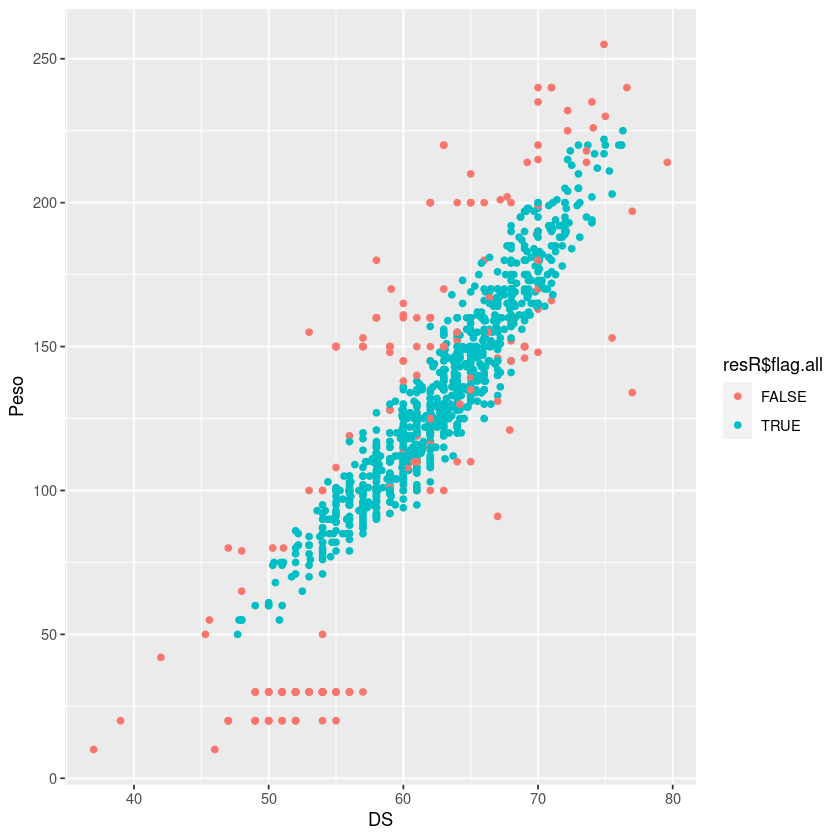

In [18]:
resR <- rospca::robpca(CleanData, kmax=20, ndir=5000)
diagPlot(resR)
table(resR$flag.all)
ggplot(data=CleanData,aes(x=DS,y=Peso,color=resR$flag.all))+geom_point()
CleanData<-CleanData%>%mutate(outlierTag=resR$flag.all)

In [7]:
#library(factoextra)
# res.pca <- prcomp(Data[,3:5], scale = TRUE)
# res.pca <- prcomp(CleanData, center=TRUE, scale = TRUE)

#fviz_eig(res.pca)
#plot(res.pca$x[,1],res.pca$x[,2])
#str(res.pca$x)

# Mahalanobis score (Aggarwal)

1. Compute the covariance matrix $\sum$ of the original data matrix D and diagonalize it as $\sum = P \Delta P^T$ .
2. Transform the data $D$ to a new de-correlated axis-system as $D' = D P$ .
3. Standardize each column of $D'$ to unit variance by dividing it with its standard deviation.
4. For each row of $D'$, report its (squared) Euclidean distance from the centroid of $D'$ as its outlier score.

Score($\bar X$)=$\sum_{j=1}^{d} \frac{|(\bar X- \bar \mu) \cdot {\bar e_{j}|^2}}{\lambda_j } $


In [12]:
# #Mahalanobis score (Aggarwal)
# D<-CleanData
# Dp<-as.matrix(D)%*%(res.pca$rotation)
# Dpscaled<-scale(Dp,center=FALSE,scale=TRUE)
# Scores<-sqrt(rowSums(scale(Dp,center=TRUE,scale=FALSE)^2))
# hist(Scores)

# Scores <- mahalanobis(CleanData, colMeans(CleanData), cov(CleanData))
# hist(Scores)


In [13]:
# X=CleanData;

# #reconstructing observations from PC subspace
# #outlier score = norm(X-Xreconstructed)
# pc.use <- 20 #using 1 PC for reconstruction
# print(c("variance explained:",sum(res.pca$sdev[1:pc.use]^2/sum(res.pca$sdev^2))))

# Xrecon<- res.pca$x[,1:pc.use]%*%t(res.pca$rotation[,1:pc.use]) #mmult transpose
# Xrecon<-scale(Xrecon,center=FALSE, scale=1/res.pca$scale)
# Xrecon<-scale(Xrecon,center=-1*res.pca$center,scale=FALSE)

# diff=abs(X-Xrecon)
# score<-rowSums(diff)

# # score<-diff%>%rowwise()%>%mutate(score=sqrt(sum(c_across(1:6)^2)))

# # dim(diff)
      
# # score<-rowSums(diff%*%t(pr.out$sdev[1:pc.use]))
# # score

# # w_1st.pc=sum(pr.out$sdev[1])
# # w_all.pc=sum(pr.out$sdev)
# # w=w_1st.pc/w_all.pc
# # score=rowSums(diff*w)

# # hist(score) #Chi-sq

# # uppr<-qchisq(0.95,df=31)
# # indexPC<-names(score[score>uppr])

# Q<-quantile(score,c(0.25,0.75))
# IQR<-Q[2]-Q[1]
# uppr<-Q[2]+1.5*IQR
# lwr<-Q[1]-1.5*IQR

# indexPC<-names(score[score>uppr|score<lwr])
# table(which(score>uppr|score<lwr))

# table(names(score)%in%indexPC)
# ggplot(data=Data,aes(x=DS,y=Peso,color=ifelse(names(score)%in%indexPC,"outlier","expected")))+
# geom_point()

# #########


# # outliersScores<-sqrt(rowSums(PCSpace^2))
# # boxplot(outliersScores)
# # hist(outliersScores)
# # Q<-quantile(outliersScores,c(0.25,0.75))
# # IQR<-Q[2]-Q[1]
# # uppr<-Q[2]+1.5*IQR
# # lwr<-Q[1]-1.5*IQR
# # uppr
# # lwr


# # outlierIndex<-names(outliersScores[outliersScores>uppr|outliersScores<lwr])
# # table(names(outliersScores)%in%outlierIndex)
# # ggplot(data=Data,aes(x=DS,y=Peso,color=ifelse(names(outliersScores)%in%outlierIndex,"outlier","expected")))+
# # geom_point()

# # outlierIndex<-order(outliersScores[outliersScores>uppr|outliersScores<lwr])
# # ggplot(data=Data,aes(x=DS,y=Peso,color=ifelse(order(outliersScores)%in%outlierIndex,"outlier","expected")))+
# # geom_point()

In [14]:
# #Looking for density based outliers
# WorkData<- Data %>%dplyr::select(Peso,DS,DCS)
# #Choosing eps value
# #Calculate distances between transactions using kNN algorithm and aggregate by breaks,
# #k=MinPts-1=3-1, MinPts=dimensionality-1
# MinPts=3;
# k=MinPts-1;
# #plot maximum kNN distance distribution, points are ordered in increasing kNN distance.
# kNNdistplot(WorkData, k = 2);
# eps=quantile(kNNdist(WorkData, k = 2),0.95);
# #eps = 0.08
# #Select eps value at the curve \"knee\"\
# abline(h=eps, col = "red", lty=2);

# #Label outliers using DBSCAN algorithm, output$cluster holds the results, 0 indicates \"noise points\" https://cran.r-project.org/web/packages/dbscan/dbscan.pdf\n",
# Clusters <- dbscan(WorkData, eps = eps, minPts = 3);

# Data<-Data%>%mutate(DBClusters=Clusters$cluster)

In [15]:
# table(as.factor(Data$DBClusters))
# 1186-1004

# ggplot(data=Data, aes(x=DS,y=Peso,color=as.factor(DBClusters)))+
# geom_point();

# ggplot(data=Data%>%filter(!DBClusters=="1"), aes(x=DS,y=Peso,color=as.factor(DBClusters)))+
# geom_point();

In [16]:
# indexDBScan<-which(!Data$DBClusters=="1") #not in Cluster 1
# # ggplot(data=Data[indexDBScan,], aes(x=DS,y=Peso,color=as.factor(DBClusters)))+
# # geom_point();
#  indexOutlier<-unique(c(indexDBScan,indexPC))

# # indexOutlier<-indexDBScan

# table(!order(Data$Zona)%in%indexOutlier)

# CleanData<-Data[!seq(1,1186)%in%indexOutlier,]

# dim(CleanData)

# # CleanData<-Data%>%dplyr::filter(DBClusters==1)

In [17]:
# ggplot(data=CleanData,aes(x=DS,y=Peso))+
# geom_point()

# Feature selection

In [21]:
#Compressing numerical variables into categorical
str(CleanData)
print(c("Sturges Classes:",SturgesBins<-round(1+log2(length(CleanData$Peso)),0)))

#"cut" splits data by range, "ntile" splits data by quantiles

#DSBinnedMids<-hist(CleanData$DS,plot=FALSE)$mids
#DCSBinnedMids<-hist(CleanData$DCS,plot=FALSE)$mids

CleanData<-CleanData%>%mutate(
    DSBinned=(cut(CleanData$DS,SturgesBins,labels=FALSE)),
    DCSBinned=(cut(CleanData$DCS,SturgesBins,labels=FALSE))
)

'data.frame':	1186 obs. of  32 variables:
 $ Peso       : num  147 87 139 159 128 83 94 129 105 125 ...
 $ DS         : num  64 57 65 69 64 56 57 63.7 60 63 ...
 $ DCS        : num  67 53 64 67 62 52 55 62.1 59 61 ...
 $ Zona.1     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Zona.2     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Zona.3     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.101  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102  : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301  : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101 : n

In [22]:
str(CleanData)

'data.frame':	1186 obs. of  34 variables:
 $ Peso       : num  147 87 139 159 128 83 94 129 105 125 ...
 $ DS         : num  64 57 65 69 64 56 57 63.7 60 63 ...
 $ DCS        : num  67 53 64 67 62 52 55 62.1 59 61 ...
 $ Zona.1     : num  1 1 1 1 1 1 1 1 1 1 ...
 $ Zona.2     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Zona.3     : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.101  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102  : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301  : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101 : n

In [30]:
# #Since zona and finca are nominal, they are one-hot encoded. 
# dummies <- dummyVars(Peso ~ Zona+Finca, data = CleanData)
# oneHot<-predict(dummies, newdata = CleanData)
# CleanData<-CleanData%>%cbind(as.data.frame(oneHot[,1:3]),as.data.frame(oneHot[,4:28]))

# #Moreover, Binned variables are ordinal, therefore they are standarised.
# features<-CleanData[,7:8];

# preProcValues <- preProcess(features, method = c("center", "scale"))
# stdFeatures<-predict(preProcValues, features)
# CleanData<-CleanData%>%mutate(DSBinnedNorm=stdFeatures$DSBinned,DCSBinnedNorm=stdFeatures$DCSBinned)

In [23]:
WorkData<-CleanData%>%filter(outlierTag==TRUE)%>%dplyr::select(Peso,starts_with("Finca."),starts_with("Zona."),ends_with("Binned"))
str(WorkData)

'data.frame':	968 obs. of  31 variables:
 $ Peso       : num  147 87 139 159 128 83 94 129 105 125 ...
 $ Finca.101  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102  : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301  : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1201 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1301 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1401 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1502 : num  0 1 0 0 1 0 1 0 1 0 ...
 $ Finca.1601 : num  0 0 0 0 0 0 0 0 0 0 .

In [24]:
descrCor <-  cor(WorkData%>%dplyr::select(-Peso))
findCorrelation(descrCor, cutoff = .75,verbose=TRUE,names=TRUE)

Compare row 26  and column  28 with corr  0.776 
  Means:  0.211 vs 0.065 so flagging column 26 
Compare row 30  and column  29 with corr  0.892 
  Means:  0.135 vs 0.057 so flagging column 30 
Compare row 27  and column  25 with corr  0.88 
  Means:  0.116 vs 0.052 so flagging column 27 
All correlations <= 0.75 


[1] "Zona.1"    "DCSBinned" "Zona.2"

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



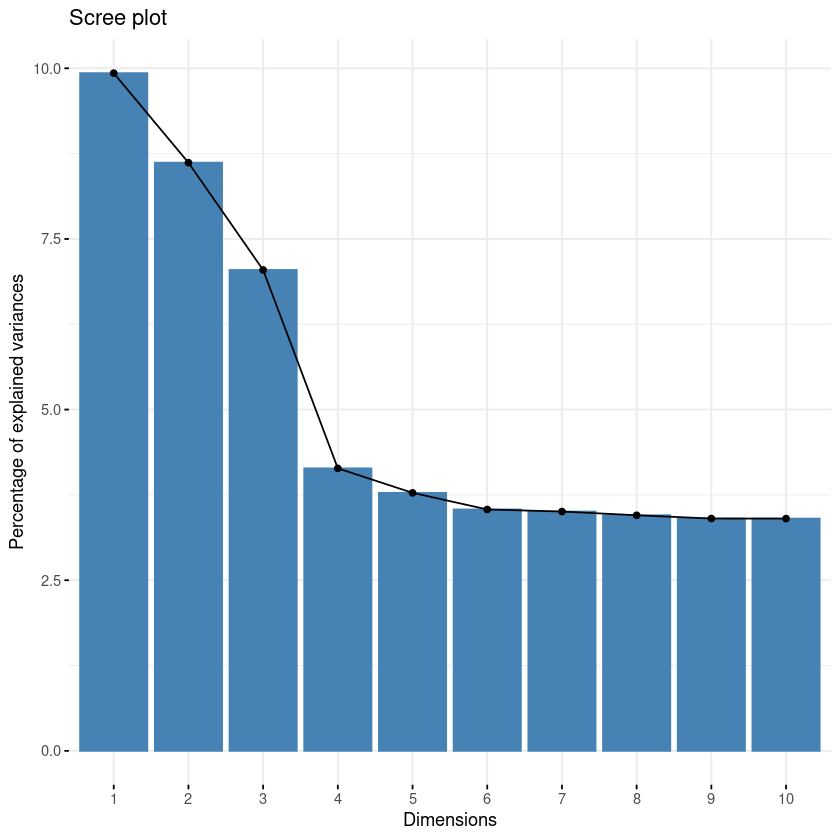

In [25]:
library(factoextra)
res.pca <- prcomp(WorkData%>%dplyr::select(-Peso), scale = TRUE)
fviz_eig(res.pca)

WorkData<-cbind(WorkData,res.pca$x)


#preProcValues <- preProcess(WorkData%>%dplyr::select(-Peso), method = c("pca"))
#PCFeatures<-predict(preProcValues, WorkData%>%dplyr::select(-Peso))
#str(PCFeatures)
#CleanData<-CleanData%>%mutate(DSBinnedNorm=stdFeatures$DSBinned,DCSBinnedNorm=stdFeatures$DCSBinned)

In [26]:
str(WorkData)

'data.frame':	968 obs. of  61 variables:
 $ Peso       : num  147 87 139 159 128 83 94 129 105 125 ...
 $ Finca.101  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.102  : num  0 0 0 0 0 0 0 1 0 0 ...
 $ Finca.201  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.301  : num  1 0 1 1 0 1 0 0 0 1 ...
 $ Finca.303  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.401  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.501  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.601  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.701  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.801  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.901  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.902  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1002 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1032 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1101 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1201 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1301 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1401 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Finca.1502 : num  0 1 0 0 1 0 1 0 1 0 ...
 $ Finca.1601 : num  0 0 0 0 0 0 0 0 0 0 .

In [27]:
eig.val <- get_eigenvalue(res.pca)
head(eig.val)

,eigenvalue,variance.percent,cumulative.variance.percent
,<dbl>,<dbl>,<dbl>
Dim.1,2.978711,9.929036,9.929036
Dim.2,2.585236,8.617453,18.546489
Dim.3,2.113605,7.045351,25.591839
Dim.4,1.241532,4.138441,29.730280
Dim.5,1.134047,3.780157,33.510437
Dim.6,1.060980,3.536600,37.047037


In [30]:
#Sampling
set.seed(3456)
trainIndex <- createDataPartition(WorkData$Peso, p = .5, 
                                  list = FALSE, 
                                  times = 1)

trainData<-(WorkData%>%dplyr::select(Peso,starts_with("Finca."),ends_with("Binned")))[trainIndex,];

testData<-(WorkData%>%dplyr::select(Peso,starts_with("Finca."),ends_with("Binned")))[-trainIndex,];


Call:
lm(formula = Peso ~ ., data = trainData)

Residuals:
     Min       1Q   Median       3Q      Max 
-26.9037  -5.0048   0.2058   5.0321  23.9061 

Coefficients: (1 not defined because of singularities)
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.1935     2.8555   0.418 0.676177    
Finca.101     0.1418     3.0066   0.047 0.962407    
Finca.102    -3.3983     1.6713  -2.033 0.042595 *  
Finca.201     4.8343     2.9266   1.652 0.099246 .  
Finca.301    -1.4086     1.4861  -0.948 0.343701    
Finca.303    10.5625     2.6123   4.043 6.18e-05 ***
Finca.401    -3.5143     3.2656  -1.076 0.282414    
Finca.501     5.1859     3.0721   1.688 0.092075 .  
Finca.601     1.2857     2.7449   0.468 0.639727    
Finca.701     5.7326     3.0947   1.852 0.064614 .  
Finca.801   -11.1927     3.2898  -3.402 0.000727 ***
Finca.901    -5.2417     3.8030  -1.378 0.168785    
Finca.902     1.3504     1.9405   0.696 0.486822    
Finca.1002    5.1532     2.2700   2.270 0.023666 *

Warning message:
“not plotting observations with leverage one:
  433, 450”


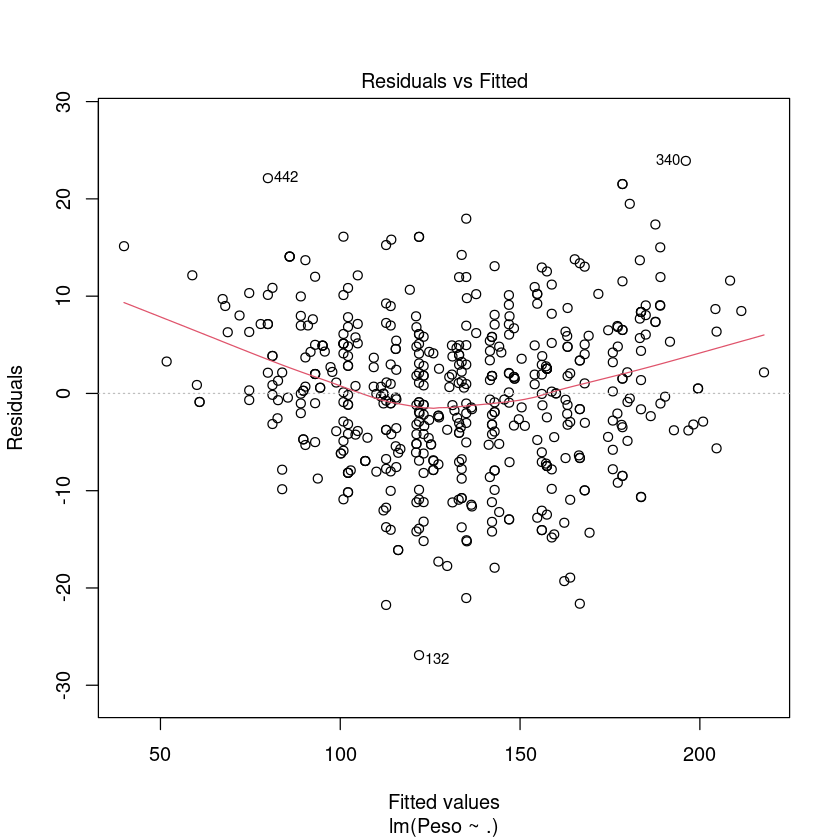

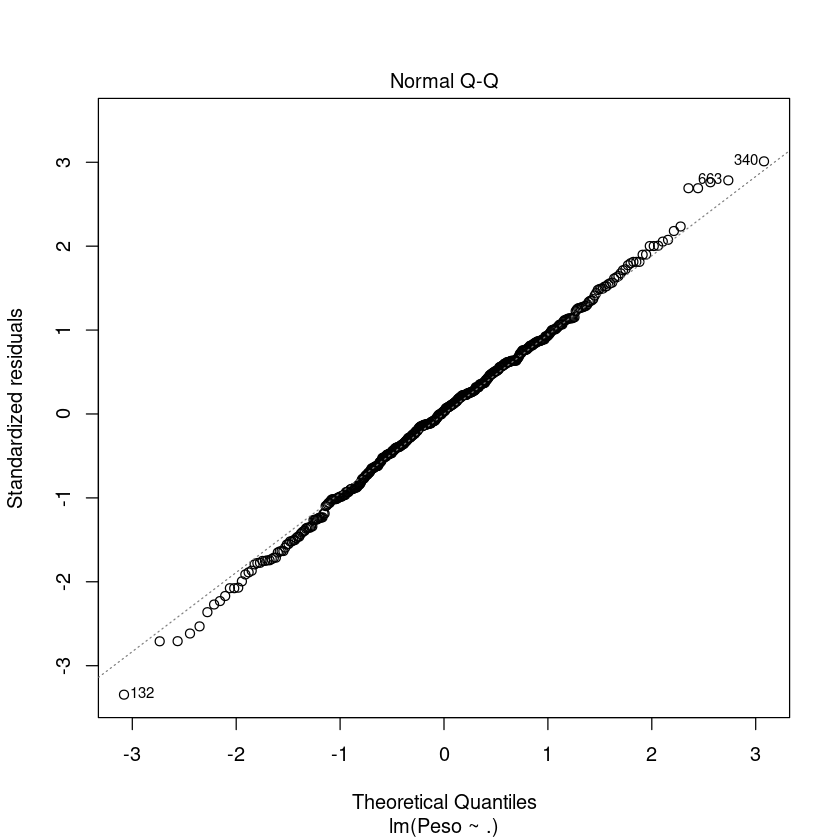

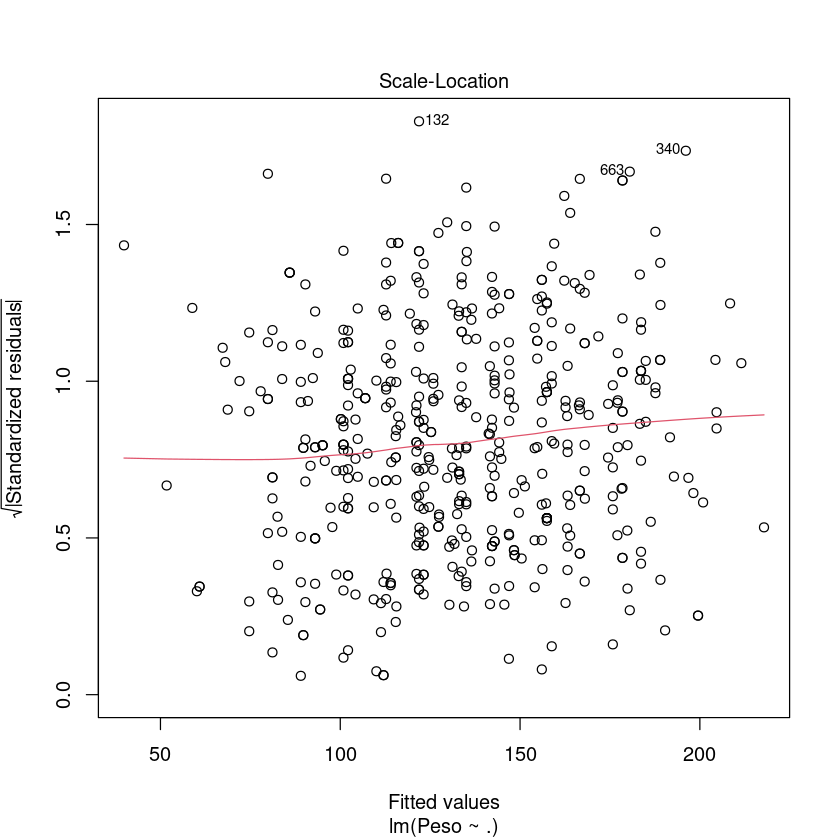

Warning message in predict.lm(lm0, testData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”


[1] "Root Mean Squared Error:" "8.02101608383784"        


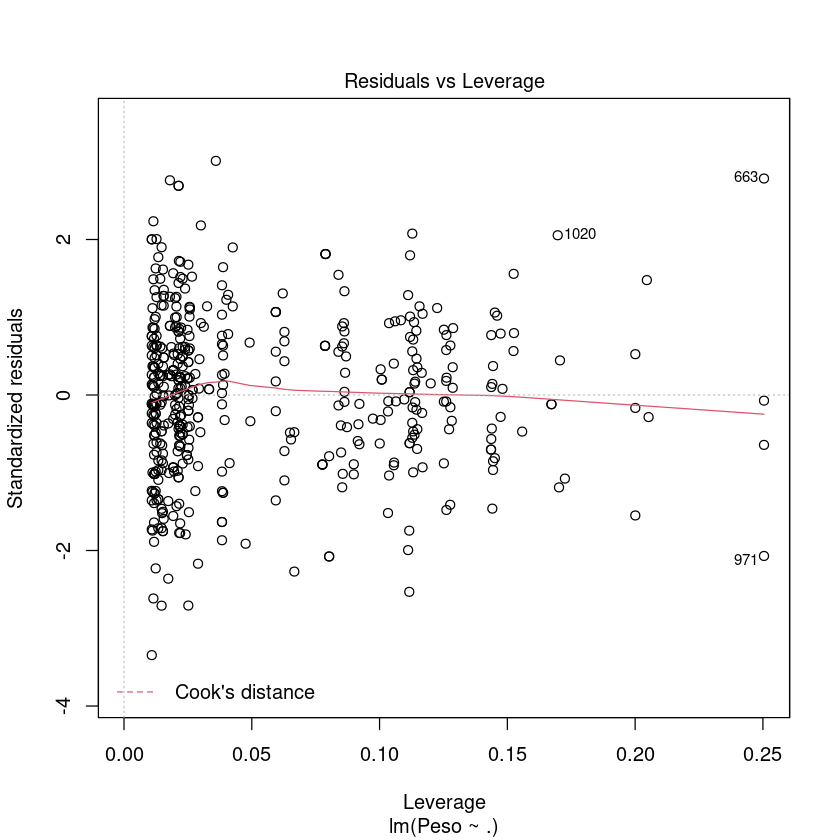

In [31]:
#Baseline model
lm0<-lm(data=trainData,Peso~.)
summary(lm0)
plot(lm0)
PesoPredict<-predict(lm0,testData,interval="prediction",level=0.95)
RMSE<-sqrt(sum((PesoPredict[,1]-testData$Peso)^2)/length(testData$Peso))
print(c("Root Mean Squared Error:",RMSE))

In [32]:
train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelLasso <- train(Peso~.,
                trControl = train_control,
                tuneLength=25,
                data=trainData,
                method="glmnet"               
                );
stopCluster(cl)
modelLasso

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

485 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 436, 436, 437, 436, 437, 438, ... 
Resampling results across tuning parameters:

  alpha   lambda       RMSE       Rsquared   MAE      
  0.1000   0.05312145   8.380992  0.9384960   6.601012
  0.1000   0.07570352   8.380992  0.9384960   6.601012
  0.1000   0.10788529   8.380992  0.9384960   6.601012
  0.1000   0.15374761   8.380992  0.9384960   6.601012
  0.1000   0.21910614   8.380992  0.9384960   6.601012
  0.1000   0.31224874   8.379167  0.9385221   6.599982
  0.1000   0.44498651   8.374246  0.9385852   6.598108
  0.1000   0.63415146   8.368435  0.9386753   6.597208
  0.1000   0.90373095   8.364729  0.9387792   6.597742
  0.1000   1.28790938   8.366008  0.9388981   6.603279
  0.1000   1.83540310   8.387493  0.9389212   6.624334
  0.1000   2.61563786   8.445527  0.9388124   6.673122
  0.1000   3.72755250   8.574872  0.9384845   6.773918
  0.1000   5.31214502   8.82818

In [33]:
train_control <- trainControl(method = "cv",number = 10)

trainDataPC<-(WorkData%>%dplyr::select(Peso,starts_with("PC")))[trainIndex,];
testDataPC<-(WorkData%>%dplyr::select(Peso,starts_with("PC")))[-trainIndex,];

cl <- makeCluster(2)
registerDoParallel(cl)
modelPC <- train(Peso~.,
                trControl = train_control,
                tuneLength=25,
                data=trainDataPC,
                method="leapBackward"
                );
stopCluster(cl)
print(modelPC)

Warning message in leaps.setup(x, y, wt = weights, nbest = nbest, nvmax = nvmax, :
“4  linear dependencies found”


Linear Regression with Backwards Selection 

485 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 437, 436, 437, 435, 436, 437, ... 
Resampling results across tuning parameters:

  nvmax  RMSE       Rsquared   MAE      
   2      20.14270  0.6420284   16.77160
   3      14.08059  0.8007627   11.14709
   4     628.68215  0.7467967   96.87499
   5     613.44733  0.7479109   94.26741
   6     629.17907  0.7481812   96.56585
   7     650.82769  0.7484264   99.60122
   8     655.52636  0.7493231  100.12842
   9     666.98796  0.7499511  101.67958
  10     672.64135  0.7523926  102.37075
  11     679.91906  0.7530230  103.36928
  12     685.97891  0.7531608  104.21455
  13     690.51176  0.7531365  104.80098
  14     691.82166  0.7535829  104.94782
  15     693.11722  0.7535716  105.10341
  16     696.33918  0.7533986  105.56816
  17     697.38683  0.7531197  105.73366
  18     696.58107  0.7531143  105.61919
  19     695.77925  0.75323

In [34]:
train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelPCLasso <- train(Peso~.,
                trControl = train_control,
                tuneLength=25,
                data=trainDataPC,
                method="glmnet"               
                );
stopCluster(cl)
modelPCLasso

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

485 samples
 30 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 437, 436, 437, 438, 437, 436, ... 
Resampling results across tuning parameters:

  alpha   lambda       RMSE       Rsquared   MAE      
  0.1000   0.03795840   8.437204  0.9366440   6.607938
  0.1000   0.05409462   8.437204  0.9366440   6.607938
  0.1000   0.07709038   8.437204  0.9366440   6.607938
  0.1000   0.10986171   8.437204  0.9366440   6.607938
  0.1000   0.15656421   8.437204  0.9366440   6.607938
  0.1000   0.22312008   8.437685  0.9366568   6.608030
  0.1000   0.31796902   8.439996  0.9366713   6.609270
  0.1000   0.45313850   8.446156  0.9366832   6.615341
  0.1000   0.64576889   8.460239  0.9366877   6.628429
  0.1000   0.92028697   8.489408  0.9366895   6.656104
  0.1000   1.31150342   8.549903  0.9366486   6.712183
  0.1000   1.86902703   8.668811  0.9364893   6.816741
  0.1000   2.66355541   8.893369  0.9361455   6.992557
  0.1000   3.79583992   9.30120

In [36]:
lm3<-lm(data=trainData,Peso~I((DSBinned+DCSBinned)/2^3))
summary(lm3)
PesoPredictLm3<-predict(lm3,testData)
summary(PesoPredictLm3)

RMSE<-sqrt(sum((PesoPredictLm3-testData$Peso)^2)/length(testData$Peso))

print(c("Polynomial Root Mean Squared Error:",RMSE))


Call:
lm(formula = Peso ~ I((DSBinned + DCSBinned)/2^3), data = trainData)

Residuals:
     Min       1Q   Median       3Q      Max 
-28.8816  -5.9366   0.1184   6.0268  25.1367 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -7.899      1.797  -4.396 1.36e-05 ***
I((DSBinned + DCSBinned)/2^3)   87.853      1.090  80.566  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.816 on 483 degrees of freedom
Multiple R-squared:  0.9307,	Adjusted R-squared:  0.9306 
F-statistic:  6491 on 1 and 483 DF,  p-value: < 2.2e-16


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.01  112.90  134.86  133.45  156.83  211.74 

[1] "Polynomial Root Mean Squared Error:" "8.21271889840257"                   


In [37]:
#Random forest

train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelRF <- train(Peso~.,
                data=trainData,
               # preProc=c("center","scale","nzv"),
                trControl = train_control,
                tuneLength=25,
                method="rf"               
                );
stopCluster(cl)

modelRF

Random Forest 

485 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 436, 437, 437, 437, 437, 437, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE      
   2    15.889461  0.8623675  12.167083
   3    12.085909  0.8987677   9.247358
   4    10.384557  0.9181666   8.141556
   5     9.480742  0.9271852   7.521727
   6     9.041462  0.9320301   7.219166
   7     8.694872  0.9353977   6.963812
   8     8.572136  0.9362146   6.856829
   9     8.439697  0.9375739   6.758240
  10     8.431407  0.9374670   6.715539
  11     8.360573  0.9383008   6.653449
  12     8.385770  0.9378467   6.662846
  13     8.356214  0.9380612   6.640544
  14     8.354045  0.9379828   6.646305
  15     8.363707  0.9379372   6.644974
  16     8.369177  0.9378368   6.650402
  17     8.382232  0.9375334   6.652898
  18     8.390365  0.9374668   6.661829
  19     8.384392  0.9375708   6.671924
  20     8.406140  0.9372701   6.6

In [38]:
#kNN

train_control <- trainControl(method = "cv",number = 10)

cl <- makeCluster(2)
registerDoParallel(cl)
modelkNN <- train(Peso~.,
                data=trainData,
               # preProc=c("center","scale","nzv"),
                trControl = train_control,
                tuneLength=20,
                method="knn"               
                );
stopCluster(cl)

modelkNN

k-Nearest Neighbors 

485 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 437, 437, 437, 437, 436, 437, ... 
Resampling results across tuning parameters:

  k   RMSE      Rsquared   MAE     
   5  8.979836  0.9326975  7.134283
   7  9.056938  0.9330908  7.278838
   9  8.987132  0.9356963  7.283205
  11  9.147690  0.9337803  7.433462
  13  9.211885  0.9333496  7.472684
  15  9.120541  0.9355997  7.406894
  17  9.117179  0.9358109  7.421618
  19  9.147029  0.9354720  7.393293
  21  9.239210  0.9347174  7.402962
  23  9.351385  0.9336643  7.487235
  25  9.358439  0.9336460  7.487683
  27  9.392032  0.9338305  7.508420
  29  9.405610  0.9344153  7.519304
  31  9.451529  0.9340385  7.554705
  33  9.502349  0.9336515  7.563049
  35  9.567846  0.9330658  7.638994
  37  9.619312  0.9325017  7.682676
  39  9.598593  0.9327796  7.658165
  41  9.579999  0.9329975  7.640556
  43  9.566117  0.9333137  7.638482

RMSE was used to select the opt

In [39]:
#print(c("Train results"))
RMSE<-matrix(1:14,nrow=7);

PesoPredictLM<-predict(lm0,trainData,interval="prediction",level=0.95)
RMSE[1,1]<-sqrt(sum((PesoPredictLM-trainData$Peso)^2)/length(trainData$Peso))
#print(c("Linear Model Root Mean Squared Error:",round(RMSE,2)))

PesoPredictLasso<-predict(modelLasso,trainData)
RMSE[2,1]<-sqrt(sum((PesoPredictLasso-trainData$Peso)^2)/length(trainData$Peso))
#print(c("Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictPC<-predict(modelPC,trainDataPC)
RMSE[3,1]<-sqrt(sum((PesoPredictPC-trainDataPC$Peso)^2)/length(trainDataPC$Peso))
#print(c("Principal Components Linear Model Root Mean Squared Error:",round(RMSE,2)))


PesoPredictPCLasso<-predict(modelPCLasso,trainDataPC)
RMSE[4,1]<-sqrt(sum((PesoPredictPCLasso-trainDataPC$Peso)^2)/length(trainDataPC$Peso))
#print(c("PC Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictRF<-predict(modelRF,trainData)
RMSE[5,1]<-sqrt(sum((PesoPredictRF-trainData$Peso)^2)/length(trainData$Peso))

PesoPredictkNN<-predict(modelkNN,trainData)
RMSE[6,1]<-sqrt(sum((PesoPredictkNN-trainData$Peso)^2)/length(trainData$Peso))

PesoPredictNL<-predict(lm3,trainData)
RMSE[7,1]<-sqrt(sum((PesoPredictNL-trainData$Peso)^2)/length(trainData$Peso))

#print(c("Random forest Root Mean Squared Error:",round(RMSE,2)))

#print(c("Test results"))

PesoPredictLM<-predict(lm0,testData,interval="prediction",level=0.95)
RMSE[1,2]<-sqrt(sum((PesoPredictLM-testData$Peso)^2)/length(testData$Peso))
#print(c("Linear Model Root Mean Squared Error:",round(RMSE,2)))

PesoPredictLasso<-predict(modelLasso,testData)
RMSE[2,2]<-sqrt(sum((PesoPredictLasso-testData$Peso)^2)/length(testData$Peso))
#print(c("Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictPC<-predict(modelPC,testDataPC)
RMSE[3,2]<-sqrt(sum((PesoPredictPC-testDataPC$Peso)^2)/length(testDataPC$Peso))
#print(c("Principal Components Linear Model Root Mean Squared Error:",round(RMSE,2)))

PesoPredictPCLasso<-predict(modelPCLasso,testDataPC)
RMSE[4,2]<-sqrt(sum((PesoPredictPCLasso-testDataPC$Peso)^2)/length(testDataPC$Peso))
#print(c("PC Lasso Root Mean Squared Error:",round(RMSE,2)))

PesoPredictRF<-predict(modelRF,testData)
RMSE[5,2]<-sqrt(sum((PesoPredictRF-testData$Peso)^2)/length(testData$Peso))
#print(c("Random forest Root Mean Squared Error:",round(RMSE,2)))

PesoPredictkNN<-predict(modelkNN,testData)
RMSE[6,2]<-sqrt(sum((PesoPredictkNN-testData$Peso)^2)/length(testData$Peso))

PesoPredictNL<-predict(lm3,testData)
RMSE[7,2]<-sqrt(sum((PesoPredictNL-testData$Peso)^2)/length(testData$Peso))


RMSE<-cbind(model=c("Linear Model","Lasso","PC Linear","PC Lasso","RF","kNN","NL"),as.data.frame(RMSE));
rename(RMSE,"trainRMSE"=V1,"testRMSE"=V2);

Warning message in predict.lm(lm0, trainData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(lm0, testData, interval = "prediction", level = 0.95):
“prediction from a rank-deficient fit may be misleading”


model,trainRMSE,testRMSE
<chr>,<dbl>,<dbl>
Linear Model,26.801553,27.010783
Lasso,7.920540,7.953208
PC Linear,11.394794,11.916832
PC Lasso,7.860580,8.028547
RF,6.452137,8.064436
kNN,7.991066,8.614309
NL,8.797948,8.212719
